In [1]:
# import dependencies 
from fastai.vision.all import *
import timm
from torchvision import transforms
from pathlib import Path

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Function to label the images (this might change based on your task)
def get_y(file_path): 
    return parent_label(file_path)

In [3]:
def create_dls(train_pct, path='PlantDoc-Dataset'):
    # Define the DataBlock
    datablock = DataBlock(
        blocks=(ImageBlock, CategoryBlock),  # Define types of input and output
        get_items=get_image_files,           # How to get the items (images)
        splitter=RandomSplitter(valid_pct=(1.0 - train_pct), seed=42),  # Split method
        get_y=get_y,                         # How to label items
        item_tfms=Resize(224),               # Item-level transformations
        # batch_tfms=aug_transforms()          # Batch-level transformations
    )
    # Create the DataLoaders
    dls = datablock.dataloaders(Path(path))
    return dls

In [4]:
def get_mean_table(results_table):
    # 1 & 2: Group by 'train_pct' and calculate the mean of 'acc'
    grouped = results_table.groupby('train_pct')['acc'].mean().reset_index()
    # 3: Create the new DataFrame
    mean_table = grouped.rename(columns={'acc': 'mean_acc'})
    return mean_table

In [5]:
# dls.show_batch()

In [6]:
!ls

FieldPlant-dataset   models		       readme.md
README.dataset.txt   plantvillage-dataset      requirements.txt
README.roboflow.txt  plantvillage-dataset.zip
app.py		     prototype.ipynb


In [6]:
train_pcts = [0.1, 0.25, 0.5, 0.65]
replicates = 3
results_table = pd.DataFrame(columns=['train_pct', 'acc'])
for train_pct in train_pcts:
    print(f'Creating DL: {train_pct}')
    dls = create_dls(train_pct)
    for replicate in range(replicates): # repeat training and average results for increased accuracy 
        print(f'{train_pct} replicate {replicate}')
        # fine tune model
        model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=dls.c)
        learn = Learner(dls, model, metrics=accuracy)
        learn.fine_tune(epochs=15)
        val_acc = learn.recorder.values[-1][2]
        row = pd.DataFrame({'train_pct': train_pct, 'acc': val_acc}, index=[0])
        results_table = pd.concat([results_table, row])

mean_table = get_mean_table(results_table)

Creating DL: 0.1
0.1 replicate 0


epoch,train_loss,valid_loss,accuracy,time
0,4.342168,3.443657,0.113240,00:12


epoch,train_loss,valid_loss,accuracy,time
0,0.870421,3.259376,0.144599,00:10
1,0.573056,3.069991,0.190331,00:10
2,0.396775,2.925069,0.240418,00:11
3,0.291539,2.852644,0.280052,00:11
4,0.225321,2.882616,0.312718,00:10
5,0.183909,2.858972,0.328397,00:10
6,0.153597,2.882805,0.339721,00:11
7,0.129008,2.875826,0.354530,00:10
8,0.111621,2.798049,0.360627,00:10
9,0.096308,2.718680,0.361934,00:10


/tmp/ipykernel_137455/3062109786.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_table = pd.concat([results_table, row])


0.1 replicate 1


epoch,train_loss,valid_loss,accuracy,time
0,4.025154,3.389152,0.126307,00:11


epoch,train_loss,valid_loss,accuracy,time
0,0.749598,3.123948,0.183798,00:11
1,0.492485,2.888948,0.239983,00:10
2,0.343353,2.748093,0.286150,00:10
3,0.252488,2.705460,0.336672,00:10
4,0.195673,2.725320,0.347997,00:10
5,0.156990,2.735563,0.361498,00:10
6,0.129185,2.731581,0.375000,00:11
7,0.108449,2.724384,0.385453,00:11
8,0.092409,2.709066,0.389373,00:10
9,0.079618,2.693483,0.385888,00:10


0.1 replicate 2


epoch,train_loss,valid_loss,accuracy,time
0,3.962311,3.347507,0.134146,00:11


epoch,train_loss,valid_loss,accuracy,time
0,0.681345,3.125238,0.173345,00:11
1,0.453100,2.889864,0.223432,00:11
2,0.315892,2.686736,0.289199,00:11
3,0.233536,2.608602,0.334059,00:11
4,0.182345,2.672618,0.344512,00:11
5,0.146165,2.760233,0.350610,00:10
6,0.120758,2.760368,0.358449,00:11
7,0.101685,2.727148,0.369774,00:11
8,0.086551,2.711505,0.369338,00:10
9,0.074586,2.704133,0.369774,00:11


Creating DL: 0.25
0.25 replicate 0


epoch,train_loss,valid_loss,accuracy,time
0,3.628299,2.719310,0.245559,00:10


epoch,train_loss,valid_loss,accuracy,time
0,0.801210,2.305228,0.335423,00:10
1,0.520686,2.059716,0.407524,00:10
2,0.346966,2.013427,0.457680,00:10
3,0.271379,2.061238,0.479101,00:10
4,0.210573,2.084084,0.482236,00:10
5,0.165480,2.048599,0.486938,00:10
6,0.134150,2.142451,0.484326,00:10
7,0.112802,2.160355,0.490073,00:10
8,0.096393,2.249711,0.477534,00:10
9,0.084115,2.221814,0.469175,00:10


0.25 replicate 1


epoch,train_loss,valid_loss,accuracy,time
0,3.461140,2.568633,0.303030,00:10


epoch,train_loss,valid_loss,accuracy,time
0,0.656103,2.252673,0.370951,00:10
1,0.421628,2.069295,0.425810,00:10
2,0.291523,2.009256,0.468652,00:10
3,0.212979,2.115928,0.474399,00:10
4,0.166277,2.203305,0.477012,00:10
5,0.133435,2.304032,0.459770,00:10
6,0.115162,2.310300,0.465517,00:10
7,0.106222,2.226698,0.468652,00:10
8,0.099572,2.246132,0.478579,00:10
9,0.090295,2.275091,0.478056,00:11


0.25 replicate 2


epoch,train_loss,valid_loss,accuracy,time
0,3.478772,2.813356,0.256008,00:10


epoch,train_loss,valid_loss,accuracy,time
0,0.738285,2.344747,0.347440,00:10
1,0.481889,2.076461,0.417450,00:10
2,0.333769,2.057404,0.444096,00:10
3,0.259138,2.143598,0.455068,00:10
4,0.202791,2.187292,0.440439,00:10
5,0.175522,2.096196,0.464995,00:10
6,0.144463,2.225433,0.458725,00:10
7,0.124171,2.212064,0.458725,00:10
8,0.108454,2.348552,0.456113,00:10
9,0.094613,2.294051,0.477012,00:10


Creating DL: 0.5
0.5 replicate 0


epoch,train_loss,valid_loss,accuracy,time
0,3.028605,1.961174,0.409091,00:12


epoch,train_loss,valid_loss,accuracy,time
0,0.610263,1.568734,0.547806,00:10
1,0.369343,1.495274,0.586991,00:10
2,0.250151,1.631474,0.571317,00:11
3,0.218250,1.757273,0.540752,00:10
4,0.220403,2.307882,0.493730,00:11
5,0.244122,2.200839,0.489028,00:10
6,0.269305,2.322156,0.503135,00:10
7,0.244964,2.267011,0.532915,00:11
8,0.194598,2.018032,0.589342,00:10
9,0.149128,2.000108,0.564263,00:10


0.5 replicate 1


epoch,train_loss,valid_loss,accuracy,time
0,2.867672,2.100243,0.419279,00:10


epoch,train_loss,valid_loss,accuracy,time
0,0.589904,1.556382,0.546238,00:10
1,0.348461,1.587405,0.575235,00:11
2,0.238798,1.682884,0.572884,00:10
3,0.196953,1.903446,0.561128,00:10
4,0.228825,2.382152,0.472571,00:10
5,0.251241,2.164301,0.523511,00:11
6,0.259939,2.367256,0.529781,00:11
7,0.230406,2.160246,0.525078,00:10
8,0.186180,1.945035,0.570533,00:10
9,0.141119,1.987078,0.587774,00:10


0.5 replicate 2


epoch,train_loss,valid_loss,accuracy,time
0,2.908813,2.166603,0.390282,00:10


epoch,train_loss,valid_loss,accuracy,time
0,0.589349,1.591524,0.548589,00:11
1,0.334490,1.594498,0.576802,00:10
2,0.224693,1.679424,0.561128,00:10
3,0.205803,1.800787,0.549373,00:10
4,0.205075,2.170452,0.506270,00:10
5,0.227509,2.354513,0.504702,00:11
6,0.246811,2.090110,0.513323,00:10
7,0.228154,2.203594,0.539969,00:11
8,0.203446,2.075926,0.564263,00:10
9,0.163353,1.923992,0.585423,00:10


Creating DL: 0.65
0.65 replicate 0


epoch,train_loss,valid_loss,accuracy,time
0,2.771528,2.100751,0.419933,00:10


epoch,train_loss,valid_loss,accuracy,time
0,0.622429,1.432395,0.585666,00:10
1,0.365268,1.548643,0.587906,00:10
2,0.258651,1.604146,0.585666,00:10
3,0.223975,1.940933,0.572228,00:11
4,0.254104,2.308479,0.484882,00:10
5,0.305244,2.454565,0.462486,00:10
6,0.312120,2.212000,0.540873,00:10
7,0.273457,2.073030,0.554311,00:10
8,0.201662,1.913298,0.586786,00:10
9,0.137665,1.831777,0.609183,00:09


0.65 replicate 1


epoch,train_loss,valid_loss,accuracy,time
0,2.649519,2.001769,0.470325,00:10


epoch,train_loss,valid_loss,accuracy,time
0,0.672479,1.480648,0.559910,00:09
1,0.395632,1.454166,0.586786,00:10
2,0.264226,1.461583,0.594625,00:09
3,0.216400,1.832583,0.563270,00:10
4,0.271778,1.973267,0.543113,00:10
5,0.323596,2.013144,0.538634,00:10
6,0.303091,2.175334,0.545353,00:10
7,0.247795,2.134821,0.566629,00:10
8,0.181836,2.035151,0.602464,00:09
9,0.135839,1.951029,0.591265,00:11


0.65 replicate 2


epoch,train_loss,valid_loss,accuracy,time
0,2.732494,1.971317,0.403136,00:10


epoch,train_loss,valid_loss,accuracy,time
0,0.583537,1.427408,0.581187,00:10
1,0.338876,1.425062,0.600224,00:10
2,0.243470,1.695829,0.559910,00:10
3,0.220111,1.956070,0.561030,00:09
4,0.290560,2.027201,0.507279,00:09
5,0.358105,1.990840,0.517357,00:09
6,0.311686,2.058591,0.575588,00:10
7,0.247040,1.995092,0.587906,00:09
8,0.177831,1.850799,0.617021,00:10
9,0.121671,1.725848,0.627100,00:10


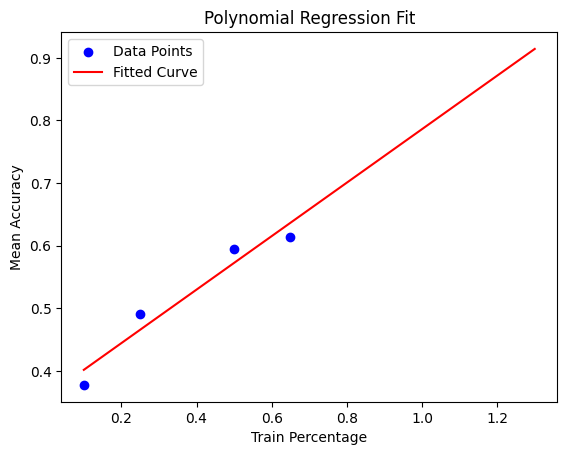

In [51]:
import numpy as np
import matplotlib.pyplot as plt

def dataset_forecast(mean_table):
    # Assuming 'mean_table' is your DataFrame with 'train_pct' and 'mean_acc'
    x = mean_table['train_pct']
    y = mean_table['mean_acc']

    # Choose the degree of the polynomial (e.g., 2 for quadratic)
    degree = 1

    # Fit the polynomial regression model
    coefficients = np.polyfit(x, y, degree)

    # Use the fitted model to predict values
    polynomial = np.poly1d(coefficients)

    # Extend the range of x_line beyond the maximum x value
    x_min = min(x)
    x_max = max(x)  # Maximum value in your data
    x_extension = 2.0  # For example, extend by 20%
    extended_x_max = x_max * x_extension

    x_line = np.linspace(x_min, extended_x_max, 100)
    y_line = polynomial(x_line)

    # Plotting the original data points
    plt.scatter(x, y, color='blue', label='Data Points')

    # Plotting the fitted curve over the extended range
    plt.plot(x_line, y_line, color='red', label='Fitted Curve')

    plt.xlabel('Train Percentage')
    plt.ylabel('Mean Accuracy')
    plt.title('Polynomial Regression Fit')
    plt.legend()
    plt.show()
    return polynomial
polynomial = dataset_forecast(mean_table)

In [52]:
percentage_of_data = 0.9
predicted_accuracy = polynomial(percentage_of_data)
predicted_accuracy

0.7434734726027394

In [47]:
train_pcts = [0.9]
replicates = 3
results_table = pd.DataFrame(columns=['train_pct', 'acc'])
for train_pct in train_pcts:
    print(f'Creating DL: {train_pct}')
    dls = create_dls(train_pct)
    for replicate in range(replicates): # repeat training and average results for increased accuracy 
        print(f'{train_pct} replicate {replicate}')
        # fine tune model
        model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=dls.c)
        learn = Learner(dls, model, metrics=accuracy)
        learn.fine_tune(epochs=15)
        val_acc = learn.recorder.values[-1][2]
        row = pd.DataFrame({'train_pct': train_pct, 'acc': val_acc}, index=[0])
        results_table = pd.concat([results_table, row])

mean_table = pd.concat([mean_table, get_mean_table(results_table)])
mean_table = mean_table.reset_index()

Creating DL: 0.9
0.9 replicate 0


epoch,train_loss,valid_loss,accuracy,time
0,2.423434,1.977059,0.462745,00:11


epoch,train_loss,valid_loss,accuracy,time
0,0.696142,1.221338,0.643137,00:11
1,0.404628,1.292615,0.654902,00:11
2,0.280121,1.259102,0.682353,00:11
3,0.288572,1.746414,0.615686,00:11
4,0.373801,1.989277,0.541176,00:11
5,0.400180,2.023148,0.584314,00:11
6,0.312328,1.828917,0.588235,00:11
7,0.213263,1.703614,0.600000,00:11
8,0.147744,1.660831,0.623529,00:11
9,0.102526,1.696829,0.615686,00:12


/tmp/ipykernel_137455/1775109075.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_table = pd.concat([results_table, row])


0.9 replicate 1


epoch,train_loss,valid_loss,accuracy,time
0,2.375181,1.964811,0.498039,00:10


epoch,train_loss,valid_loss,accuracy,time
0,0.700550,1.304918,0.631373,00:11
1,0.404100,1.317392,0.619608,00:11
2,0.278024,1.352002,0.635294,00:11
3,0.265118,1.623054,0.541176,00:11
4,0.364561,1.990284,0.549020,00:11
5,0.396466,2.013507,0.529412,00:11
6,0.344148,1.528003,0.615686,00:11
7,0.255492,1.639494,0.631373,00:11
8,0.172421,1.501912,0.654902,00:11
9,0.114252,1.481672,0.658824,00:12


0.9 replicate 2


epoch,train_loss,valid_loss,accuracy,time
0,2.437506,1.704019,0.458824,00:11


epoch,train_loss,valid_loss,accuracy,time
0,0.657663,1.249535,0.639216,00:12
1,0.359282,1.268273,0.627451,00:11
2,0.255057,1.485226,0.568627,00:11
3,0.287986,2.025143,0.525490,00:11
4,0.412204,1.777647,0.584314,00:13
5,0.447758,1.555402,0.584314,00:10
6,0.325867,1.575085,0.611765,00:10
7,0.220008,1.492286,0.658824,00:11
8,0.147074,1.475756,0.678431,00:11
9,0.094748,1.479149,0.670588,00:11


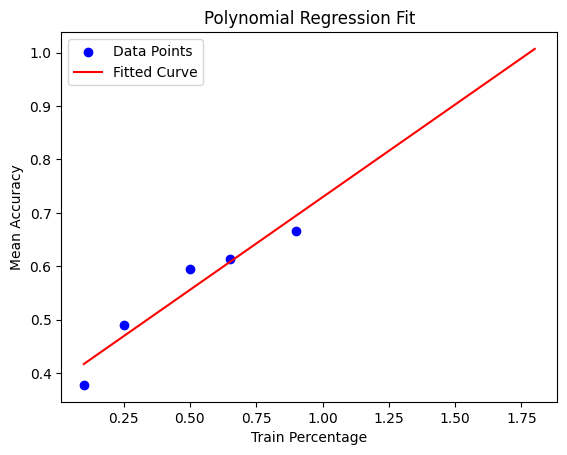

In [48]:
# plot polynomial here
polynomial = dataset_forecast(mean_table)

In [44]:
percentage_of_data = 0.95
predicted_accuracy = polynomial(percentage_of_data)
predicted_accuracy

0.7091370467574354

In [ ]:
# Resnet-18
# epoch	train_loss	valid_loss	accuracy	time
# 0	2.329669	2.175517	0.398039	04:44
# 1	2.047739	1.710715	0.527451	04:47
# 2	1.696105	1.822478	0.431373	04:57
# 3	1.373082	1.125379	0.621569	05:14
# 4	1.118939	1.178962	0.613725	05:16
# 5	0.903016	1.063396	0.656863	05:16
# 6	0.726309	0.970530	0.662745	05:16
# 7	0.587566	0.937186	0.670588	05:15
# 8	0.492905	0.925825	0.688235	05:04
# 9	0.435941	0.922592	0.692157	04:56

In [ ]:
learn.save('fine_tuned_model')

Path('models/fine_tuned_model.pth')

In [13]:
train_pcts = [0.1, 0.25, 0.5, 0.65]
replicates = 3
field_plant_results_table = pd.DataFrame(columns=['train_pct', 'acc'])
for train_pct in train_pcts:
    print(f'Creating DL: {train_pct}')
    dls = create_dls(train_pct, 'plantvillage-dataset/color')
    for replicate in range(replicates): # repeat training and average results for increased accuracy 
        print(f'{train_pct} replicate {replicate}')
        # fine tune model
        model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=dls.c)
        learn = Learner(dls, model, metrics=accuracy)
        learn.fine_tune(epochs=15)
        val_acc = learn.recorder.values[-1][2]
        row = pd.DataFrame({'train_pct': train_pct, 'acc': val_acc}, index=[0])
        field_plant_results_table = pd.concat([field_plant_results_table, row])

Creating DL: 0.1
0.1 replicate 0


model.safetensors: 100%|██████████| 21.4M/21.4M [00:00<00:00, 72.0MB/s]


epoch,train_loss,valid_loss,accuracy,time
0,0.749217,0.354074,0.896816,00:31


epoch,train_loss,valid_loss,accuracy,time
0,0.059449,0.063277,0.980480,00:30
1,0.035489,0.070229,0.978005,00:31
2,0.069403,0.270690,0.928142,00:31
3,0.137486,0.421016,0.910013,00:31
4,0.085027,0.133387,0.960347,00:32
5,0.044047,0.082115,0.977677,00:30
6,0.045920,0.093329,0.971150,00:29
7,0.036764,0.142979,0.964439,00:30
8,0.029737,0.088654,0.976061,00:29
9,0.011302,0.075202,0.981606,00:30


/tmp/ipykernel_12576/4076984404.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  field_plant_results_table = pd.concat([field_plant_results_table, row])


0.1 replicate 1


epoch,train_loss,valid_loss,accuracy,time
0,0.693908,0.409964,0.882289,00:31


epoch,train_loss,valid_loss,accuracy,time
0,0.058188,0.073041,0.977821,00:30
1,0.023431,0.103005,0.970864,00:31
2,0.083595,0.236338,0.934505,00:30
3,0.105444,0.425468,0.915783,00:30
4,0.101371,0.165100,0.954106,00:31
5,0.061875,0.109718,0.969636,00:31
6,0.047928,0.131452,0.964337,00:31
7,0.027618,0.079455,0.978905,00:31
8,0.017733,0.080853,0.978168,00:31
9,0.015199,0.096501,0.974363,00:31


KeyboardInterrupt: 

In [ ]:
# polynomial = dataset_forecast(field_plant_results_table)

In [14]:
train_pcts = [0.1, 0.25, 0.5, 0.65]
replicates = 3
field_plant_results_table = pd.DataFrame(columns=['train_pct', 'acc'])
for train_pct in train_pcts:
    print(f'Creating DL: {train_pct}')
    dls = create_dls(train_pct, 'plantvillage-dataset/segmented')
    for replicate in range(replicates): # repeat training and average results for increased accuracy 
        print(f'{train_pct} replicate {replicate}')
        # fine tune model
        model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=dls.c)
        learn = Learner(dls, model, metrics=accuracy)
        learn.fine_tune(epochs=15)
        val_acc = learn.recorder.values[-1][2]
        row = pd.DataFrame({'train_pct': train_pct, 'acc': val_acc}, index=[0])
        field_plant_results_table = pd.concat([field_plant_results_table, row])

Creating DL: 0.1
0.1 replicate 0


epoch,train_loss,valid_loss,accuracy,time
0,0.769747,0.381510,0.892051,00:31


epoch,train_loss,valid_loss,accuracy,time
0,0.096039,0.105665,0.965606,00:31


KeyboardInterrupt: 

In [15]:
dls = create_dls(0.8, 'plantvillage-dataset/segmented')
# for replicate in range(replicates): # repeat training and average results for increased accuracy 
# print(f'{train_pct} replicate {replicate}')
# # fine tune model
model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=dls.c)
learn = Learner(dls, model, metrics=accuracy)
learn.fine_tune(epochs=15)

epoch,train_loss,valid_loss,accuracy,time
0,0.218748,0.186797,0.943375,01:14


epoch,train_loss,valid_loss,accuracy,time
0,0.028185,0.028797,0.991069,01:15
1,0.024148,0.048790,0.984992,01:12
2,0.049139,0.063759,0.982414,01:14
3,0.075175,0.042461,0.987202,01:15
4,0.051158,0.059039,0.980757,01:17
5,0.031880,0.105294,0.970905,01:15
6,0.036074,0.039241,0.987939,01:16
7,0.016962,0.046789,0.985453,01:15
8,0.011699,0.037058,0.992450,01:17
9,0.005284,0.023722,0.992910,01:13


epoch,train_loss,valid_loss,accuracy,time
0,0.175893,0.133349,0.959484,01:12


epoch,train_loss,valid_loss,accuracy,time
0,0.017754,0.015010,0.995028,01:14


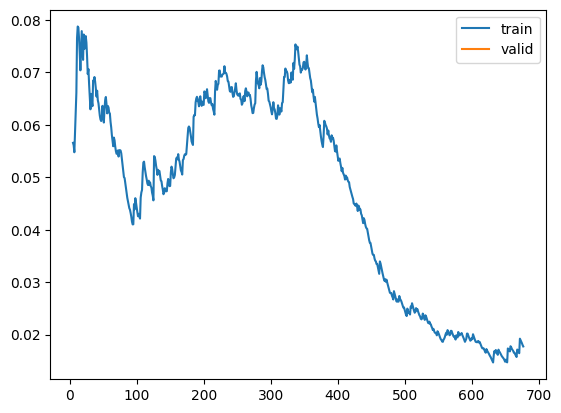

In [6]:
dls = create_dls(0.8, 'plantvillage-dataset/color')
model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=dls.c)
learn = Learner(dls, model, metrics=accuracy)
learn.fine_tune(epochs=1)
learn.recorder.plot_loss() 

In [8]:
# dls = create_dls(0.8, 'FieldPlant-dataset')
# learn.dls = dls

In [ ]:
def create_dls(train_pct, path='PlantDoc-Dataset'):
    # Define the DataBlock
    datablock = DataBlock(
        blocks=(ImageBlock, CategoryBlock),  # Define types of input and output
        get_items=get_image_files,           # How to get the items (images)
        splitter=RandomSplitter(valid_pct=(1.0 - train_pct), seed=42),  # Split method
        get_y=get_y,                         # How to label items
        item_tfms=Resize(224),               # Item-level transformations
        # batch_tfms=aug_transforms()          # Batch-level transformations
    )
    # Create the DataLoaders
    dls = datablock.dataloaders(Path(path))
    return dls

In [1]:
from fastai.vision.all import *
from sklearn.model_selection import train_test_split
import os

def create_dls_stratified(train_pct, path='PlantDoc-Dataset'):
    # Gather all image file paths and their corresponding labels
    files = get_image_files(path)
    labels = [parent_label(f) for f in files]

    # Perform a stratified split
    train_idxs, valid_idxs = train_test_split(
        range(len(files)),
        train_size=1 - train_pct,
        stratify=labels
    )

    # Function to split the dataset based on the indices
    def splitter(items): 
        return train_idxs, valid_idxs

    # Create DataBlock
    plants = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=get_image_files,
        splitter=splitter,
        get_y=parent_label,
        item_tfms=Resize(460),
        batch_tfms=aug_transforms(size=224, min_scale=0.75)
    )

    return plants.dataloaders(Path(path))

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load the new dataset
dls = create_dls_stratified(0.5, 'FieldPlant-dataset')

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [ ]:
# Update the learner's dataloaders
learn.dls = dls

# Get the number of classes in the new dataset
num_classes_new = dls.c

# Replace the final layer of the model to match the new number of classes
# Assuming the final layer is named 'classifier' which is common in timm models
# Note: The naming might vary, so ensure to adjust according to your model's architecture
learn.model.classifier = nn.Linear(learn.model.classifier.in_features, num_classes_new)

# Now you can evaluate the model on the new dataset
learn.validate()


In [30]:
dls.voca

['Cassava Bacterial Blight', 'Cassava Bacterial Blight_multiple', 'Cassava Brown Leaf Spot', 'Cassava Brown Leaf Spot Cassava Healthy', 'Cassava Brown Leaf Spot Cassava Healthy_multiple', 'Cassava Brown Leaf Spot Cassava Mosaic', 'Cassava Brown Leaf Spot_multiple', 'Cassava Brown Leaf Spot_multiple Cassava Healthy', 'Cassava Brown Leaf Spot_multiple Cassava Healthy_multiple', 'Cassava Healthy', 'Cassava Healthy Cassava Mosaic', 'Cassava Healthy Corn Brown Spots', 'Cassava Healthy_multiple', 'Cassava Healthy_multiple Cassava Mosaic', 'Cassava Mosaic', 'Cassava Mosaic_multiple', 'Cassava Root Rot', 'Cassava Root Rot_multiple', 'Corn Brown Spots', 'Corn Brown Spots Corn Healthy', 'Corn Brown Spots_multiple', 'Corn Charcoal', 'Corn Chlorotic Leaf Spot', 'Corn Gray leaf spot', 'Corn Gray leaf spot_multiple', 'Corn Healthy', 'Corn Healthy Corn leaf blight', 'Corn Healthy Corn leaf blight_multiple', 'Corn Healthy_multiple', 'Corn Healthy_multiple Corn leaf blight', 'Corn Healthy_multiple Corn

In [32]:
learn.vocab

AttributeError: 'EfficientNet' object has no attribute 'vocab'

In [33]:
n_classes_new = len(dls.vocab)
learn.model[-1] = nn.Linear(224, n_classes_new)

TypeError: 'EfficientNet' object does not support item assignment